# Gain of DRN populations and networks

Shown in figs. 5, 6, 5S3.

In [1]:
from common import colors, pvalue_thresholds, savefig

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [3]:
import warnings
import re
import copy

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid
from scipy import stats

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))
IMG_PATH = None

In [5]:
def infer_gaba_condition(dir_name):
    regex_match = re.search(r'GABA_(.*)', dir_name)
    if regex_match is not None:
        condition = regex_match.groups()[-1]
    elif 'endocannabinoid' == dir_name:
        condition = 'endocannabinoid'
    else:
        raise ValueError('Unrecognized GABA condition {}'.format(dir_name))
    return condition

In [6]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'step_input')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

network_models = [
    'DRN_homogenous_GABA_only',
    'DRN_homogenous_adaptation_swap',
    'DRN_homogenous_base',
    'DRN_subsample_adaptation_swap',
    'DRN_subsample_base',
    'DRN_subsample_fixedIA',
    'DRN_subsample_noIA',
    'mPFC_base'
]

for network_model in network_models:
    for gaba_condition in os.listdir(os.path.join(DATA_PATH, network_model)):
        for fname in os.listdir(os.path.join(DATA_PATH, network_model, gaba_condition)):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                )
                sim_dict['Mod type'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(infer_gaba_condition(gaba_condition))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, network_model, gaba_condition, fname), 
                        mode = 'r'
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,mPFC,KO,base,[ser],0
1,mPFC,KO,base,[ser],1
2,mPFC,KO,base,[ser],2
3,mPFC,KO,base,[ser],3
4,mPFC,KO,base,[ser],4


In [7]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [8]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 99.8%
Done!


In [9]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Principal PSTH': [], 'GABA PSTH': []}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
        for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'Principal PSTH'].tolist()
            ))
            psth_dict['GABA PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'GABA PSTH'].tolist()
            ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [10]:
psth_df.head()

,Circuit,Condition,GABA PSTH,Mod type,Principal PSTH
0,mPFC,KO,"[None, None, None, None, None, None, None, Non...",base,"[[[1.1333333333333335, 1.1333333333333335, 1.1..."
1,DRN,KO,"[None, None, None, None, None, None, None, Non...",homogenous_GABA_only,"[[[0.06666666666666667, 0.06666666666666667, 0..."
2,DRN,base,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",homogenous_GABA_only,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,DRN,endocannabinoid,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",homogenous_GABA_only,"[[[0.03333333333333333, 0.03333333333333333, 0..."
4,DRN,KO,"[None, None, None, None, None, None, None, Non...",homogenous_adaptation_swap,"[[[0.06666666666666667, 0.06666666666666667, 0..."


In [11]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type), 
        psth_type
    ].item()

In [12]:
def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = timeToIndex(step_start_time, 0.1)[0]
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., step_start_ind:].mean(axis=2).mean(axis=1) - baseline

def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, cov=False, dt=0.1):
    """
    Returns
    -------
    (gain, intercept) if cov = False, or (gain, intercept, parameter_covariance_matrix) if cov=True.
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = timeToIndex(step_start_time, dt)[0]
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., timeToIndex(baseline_start_time, dt)[0]:step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs, V = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1, cov=cov)
    
    if cov:
        return coeffs[0, :], coeffs[1, :], V
    else:
        return coeffs[0, :], coeffs[1, :]

In [13]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [14]:
def plot_lines_cmap(x, y, cmap, start=0., stop=1., ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    colors = cmap(np.linspace(start, stop, np.shape(y)[1]))
    for i in range(np.shape(y)[1]):
        ax.plot(x, y[:, i], color=colors[i], **pltargs)

In [15]:
class GainSimulationVisualizer(object):
    def __init__(
        self,
        psth_dataframe,
        step_amplitudes,
        baseline_interval,
        stimulus_interval,
        dt=0.1,
    ):
        """Initialize GainSimulationVisualizer.

        Arguments
        ---------
        psth_dataframe : pandas.DataFrame
        step_amplitudes : 1D float array
        baseline_interval, stimulus_interval : pair of floats
            Time window to extract baseline/stimulus (ms).
        dt : float, default 0.1
            Time step (ms).

        """
        self.psth_dataframe = psth_dataframe
        self.step_amplitudes = step_amplitudes
        self.baseline_interval = baseline_interval
        self.stimulus_interval = stimulus_interval
        self.dt = dt

    def plot_gain(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot gain over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.gain - gain_estimator.gainUncertainty,
            gain_estimator.gain + gain_estimator.gainUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.gain, label=label, **pltargs)

    def plot_intercept(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot intercept over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.intercept - gain_estimator.interceptUncertainty,
            gain_estimator.intercept + gain_estimator.interceptUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.intercept, label=label, **pltargs)

    def _fit_gain_estimator(self, circuit, condition, mod_type, psth_type):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        gain_estimator = GainEstimator(self.dt)
        gain_estimator.fit(
            dset,
            self.step_amplitudes,
            self.baseline_interval,
            self.stimulus_interval,
        )
        return gain_estimator
    
    def plot_psth(self, circuit, condition, mod_type, psth_type, sweeps, cmap, ax=None, label=None, **pltargs):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        psth_mean = dset[..., self._get_stimulus_slice()].mean(axis=0)
        psth_std = dset[..., self._get_stimulus_slice()].std(axis=0)
        
        if ax is None:
            ax = plt.gca()
        
        colors = cmap(np.linspace(0.3, 1., psth_mean.shape[0]))
        labeled_flag = False
        for i in sweeps:
            ax.fill_between(
                self._get_time_support(), 
                psth_mean[i, :] - psth_std[i, :], 
                psth_mean[i, :] + psth_std[i, :], 
                color=colors[i], 
                alpha=0.7,
                lw=0,
                **pltargs
            )
            if not labeled_flag:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], label=label, **pltargs)
                labeled_flag = True
            else:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], **pltargs)
    
    def _get_stimulus_slice(self):
        return slice(*timeToIndex(self.stimulus_interval, self.dt))

    def _get_time_support(self):
        return np.arange(
            0.0,
            (self.stimulus_interval[1] - self.stimulus_interval[0])
            - 0.5 * self.dt,
            self.dt,
        )

In [16]:
visualizer = GainSimulationVisualizer(psth_df, step_amplitudes, (800., 900.), (1000., 1900.))

# Publication figures
## Interpretation of network output

In [17]:
class PSTHToGainIllustration(object):
    def __init__(
        self,
        gain_simulation_visualizer,
        marked_times=[],
        marker_fmt_strings=[],
        marker_labels=[],
        markeredgecolor='none',
        markeredgewidth=1,
        ebar_params={'ls': 'none', 'capsize': 3, 'ecolor': 'k', 'markersize': 3, 'elinewidth': 1.5},
    ):
        if len(marked_times) != len(marker_fmt_strings):
            raiseExpectedGot(
                'equal number of values', 
                'arguments `marked_times` and `marker_fmt_strings`', 
                'lists of length {} and {}'.format(len(marked_times), len(marker_fmt_strings))
            )
        if len(marker_labels) != 0 and len(marker_labels) != len(marked_times):
            raiseExpectedGot(
                'list of same length as `marked_times`, or empty list', 
                'argument `marker_labels`', 
                'list of length {}'.format(len(marker_labels))
            )

        self._visualizer = gain_simulation_visualizer
        self._marked_times = marked_times
        self._marker_fmt_strings = marker_fmt_strings
        self._marker_labels = marker_labels
        self.markeredgecolor = markeredgecolor
        self.markeredgewidth = markeredgewidth
        self.ebar_params = ebar_params
    
    @property
    def _step_amplitudes(self):
        return self._visualizer.step_amplitudes
    
    def select_PSTH_dataset(self, circuit, condition, mod_type, psth_type):
        self._dataset_identifiers = {
            'circuit': circuit,
            'condition': condition,
            'mod_type': mod_type,
            'psth_type': psth_type
        }
        self._psth_dataset = select_PSTH_dataset(self._visualizer.psth_dataframe, **self._dataset_identifiers)
    
    def plot_PSTH_to_gain(self, cmap, color, label, file_name=None):
        plt.figure(figsize=(6, 1.5))
        
        plt.subplot(131)
        self.plot_marked_PSTH(cmap)
        plt.ylabel('{} pop. firing rate\n(Hz/neuron)'.format(label))
        plt.xlabel('Time from step onset (ms)')
        plt.legend(markerscale=1)
        
        plt.subplot(132)
        self.plot_fi_curves(fit_pltargs={'zorder': -1, 'lw': 1, 'ls': '--', 'color': 'gray'})
        plt.ylabel('{} pop. firing rate\n(Hz/neuron)'.format(label))
        plt.xlabel('Step amplitude (nA)')
        
        plt.subplot(133)
        self.plot_marked_gain(color)
        plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
        plt.xlabel('Time from step onset (ms)')
        
        sns.despine(trim=True)

        plt.tight_layout()
        
        if file_name is not None:
            savefig(file_name)
    
    def plot_marked_PSTH(self, cmap, ax=None):
        if ax is None:
            ax = plt.gca()
        
        self._visualizer.plot_psth(sweeps=range(0, 10, 3), cmap=cmap, ax=ax, **self._dataset_identifiers)
        if len(self._marker_labels) != 0:
            for time, fmt_string, label in zip(
                self._marked_times, self._marker_fmt_strings, self._marker_labels
            ):
                ax.plot(
                    [time - self._visualizer.stimulus_interval[0]] * 4,
                    self._psth_dataset[:, ::3, timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    fmt_string,
                    label=label,
                    markeredgecolor=self.markeredgecolor,
                    markeredgewidth=self.markeredgewidth
                )
        else:
            for time, fmt_string in zip(
                self._marked_times, self._marker_fmt_strings
            ):
                ax.plot(
                    [time - self._visualizer.stimulus_interval[0]] * 4,
                    self._psth_dataset[:, ::3, timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    fmt_string,
                    markeredgecolor=self.markeredgecolor,
                    markeredgewidth=self.markeredgewidth
                )
    
    def plot_fi_curves(self, curves='all', fitted=True, fit_pltargs={}, ax=None):
        """Plot population f/I curves.
        
        Arguments
        ---------
        curves: iterable of ints or `all`
            Plot f/I curves corresponding to these indices of `marked_times`.
        fitted: boolean, default True
            Whether to plot a linear fit to each f/I curve.
        fit_pltargs: dict
            Formatting parameters for linear fits. Passed to ax.plot() as keyword
            arguments.
        ax: matplotlib Axes
            Defaults to current axes.
        
        """
        if ax is None:
            ax = plt.gca()
        
        if curves == 'all':
            curves = range(len(self._marker_labels))
        
        ebar_params = copy.deepcopy(self.ebar_params)
        line_style = ebar_params.pop('ls', None) 
        if line_style is None:
            ebar_params.pop('linestyle', None)
        
        for ind in curves:
            time = self._marked_times[ind]
            fmt_string = self._marker_fmt_strings[ind]
            
            if len(self._marker_labels) != 0:
                ax.plot(
                    self._step_amplitudes,
                    self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    fmt_string,
                    markeredgecolor=self.markeredgecolor,
                    markeredgewidth=self.markeredgewidth,
                    markersize=ebar_params.get('markersize', 3),
                    label=self._marker_labels[ind],
                    ls='none',
                    zorder=2
                )
            else:
                ax.plot(
                    self._step_amplitudes,
                    self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    fmt_string,
                    markeredgecolor=self.markeredgecolor,
                    markeredgewidth=self.markeredgewidth,
                    markersize=ebar_params.get('markersize', 3),
                    ls='none',
                    zorder=2
                )
                
            err_fmt_string = copy.deepcopy(fmt_string)
            err_fmt_string = err_fmt_string.replace('.', '').replace('o', '').replace('s', '').replace('^', '')
                
            ax.errorbar(
                x=self._step_amplitudes,
                y=self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                yerr=self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].std(axis=0),
                fmt=err_fmt_string,
                marker=None,
                mew=1,
                ls='none',
                zorder=1,
                **ebar_params
            )
            
            if line_style is not None:
                ax.plot(
                    self._step_amplitudes,
                    self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    fmt_string,
                    ls=line_style,
                    marker=None,
                    zorder=-1
                )
        
        if fitted:
            for ind in curves:
                time = self._marked_times[ind]
                plot_linear_fit(
                    x=self._step_amplitudes,
                    y=self._psth_dataset[..., timeToIndex(time, self._visualizer.dt)[0]].mean(axis=0),
                    ax=ax,
                    **fit_pltargs
                )
    
    def plot_marked_gain(self, color, ax=None):
        if ax is None:
            ax = plt.gca()
        
        self._visualizer.plot_gain(ax=ax, color=color, **self._dataset_identifiers)

        gain = GainEstimator(self._visualizer.dt)
        gain.fit(
            self._psth_dataset,
            self._step_amplitudes, 
            self._visualizer.baseline_interval, 
            self._visualizer.stimulus_interval
        )

        for time, fmt_string in zip(
            self._marked_times, self._marker_fmt_strings
        ):
            ax.plot(
                [time - self._visualizer.stimulus_interval[0]], 
                [gain.gain[timeToIndex(time - self._visualizer.stimulus_interval[0], self._visualizer.dt)[0]]],
                fmt_string,
                markeredgecolor=self.markeredgecolor,
                markeredgewidth=self.markeredgewidth
            )
            
    def copy(self):
        return copy.deepcopy(self)

In [18]:
gain_illustrator = PSTHToGainIllustration(
    visualizer, 
    marked_times=[1040., 1850.], 
    marker_fmt_strings=['ko', 'ks'], 
    marker_labels=['Early', 'Late'],
    markeredgecolor='white',
    markeredgewidth=0.3
)

Saving svg
Saving png
Done!


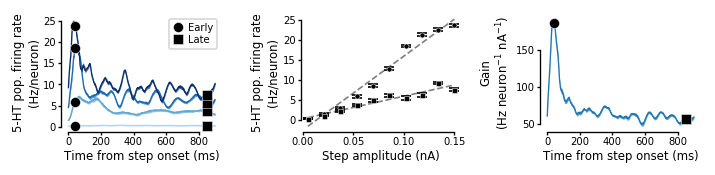

In [19]:
gain_illustrator.select_PSTH_dataset('DRN', 'KO', 'subsample_base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), colors['ser'], '5-HT', os.path.join(IMG_PATH, 'control_gain_illustration')
)

Saving svg
Saving png
Done!


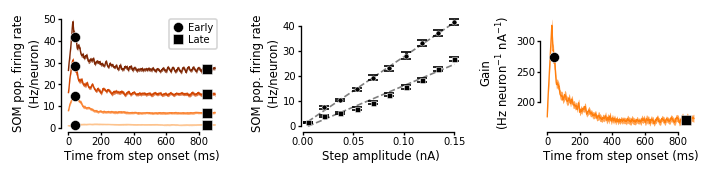

In [20]:
gain_illustrator.select_PSTH_dataset('DRN', 'base', 'subsample_base', 'GABA PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Oranges'), colors['som'], 'SOM', os.path.join(IMG_PATH, 'som_gain_illustration')
)

Saving svg
Saving png
Done!


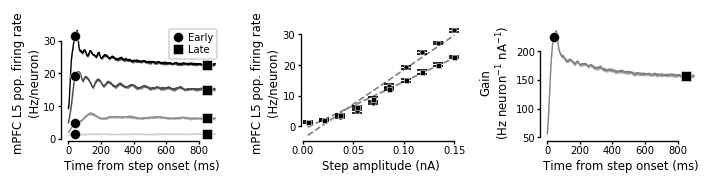

In [21]:
gain_illustrator.select_PSTH_dataset('mPFC', 'KO', 'base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Greys'), colors['pyr'], 'mPFC L5', os.path.join(IMG_PATH, 'mpfc_gain_illustration')
)

Saving svg
Saving png
Done!


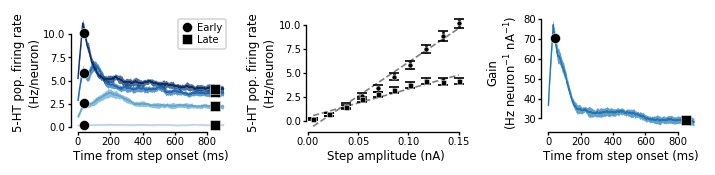

In [22]:
gain_illustrator.select_PSTH_dataset('DRN', 'base', 'subsample_base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), colors['ser'], '5-HT', os.path.join(IMG_PATH, 'ser_base_gain_illustration')
)

Saving svg
Saving png
Done!


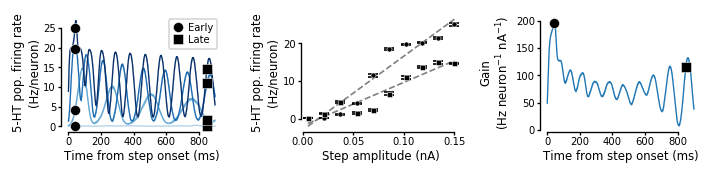

In [23]:
gain_illustrator.select_PSTH_dataset('DRN', 'KO', 'homogenous_base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), colors['ser'], '5-HT', os.path.join(IMG_PATH, 'ser_homogenous_no_FFI_illustration')
)

Saving svg
Saving png
Done!


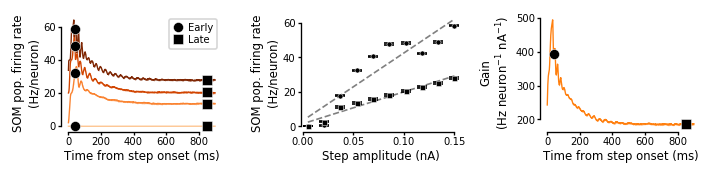

In [24]:
gain_illustrator.select_PSTH_dataset('DRN', 'base', 'homogenous_base', 'GABA PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Oranges'), 
    colors['som'], 
    'SOM', 
    os.path.join(IMG_PATH, 'som_homogenous_gain_illustration')
)

Saving svg
Saving png
Done!


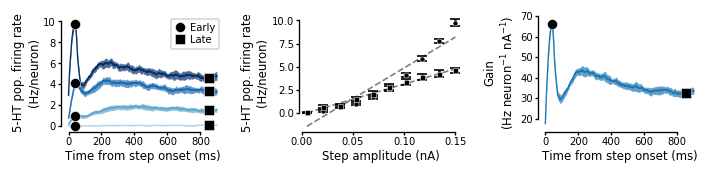

In [25]:
gain_illustrator.select_PSTH_dataset('DRN', 'base', 'homogenous_GABA_only', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), 
    colors['ser'], 
    '5-HT', 
    os.path.join(IMG_PATH, 'ser_homogenous_gaba_only_gain_illustration')
)

Saving svg
Saving png
Done!


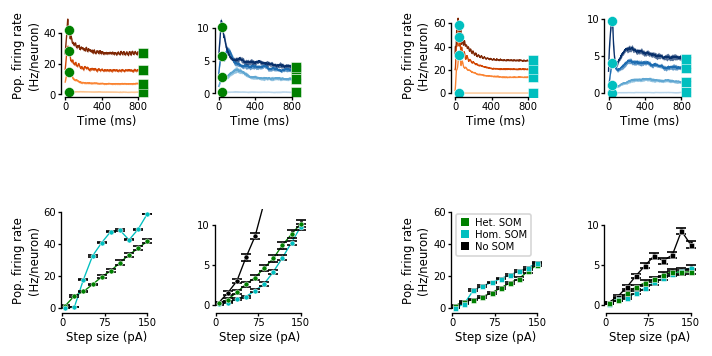

In [26]:
visualizers = {
    'no_ffi_ser': gain_illustrator.copy(),
    'het_ffi_ser': gain_illustrator.copy(),
    'homo_ffi_ser': gain_illustrator.copy(),
    'het_som': gain_illustrator.copy(),
    'homo_som': gain_illustrator.copy()
}
visualizers['no_ffi_ser'].select_PSTH_dataset('DRN', 'KO', 'subsample_base', 'Principal PSTH')
visualizers['no_ffi_ser']._marker_fmt_strings = ['ko', 'ks']
visualizers['het_ffi_ser'].select_PSTH_dataset('DRN', 'base', 'subsample_base', 'Principal PSTH')
visualizers['het_ffi_ser']._marker_fmt_strings = ['go', 'gs']
visualizers['homo_ffi_ser'].select_PSTH_dataset('DRN', 'base', 'homogenous_GABA_only', 'Principal PSTH')
visualizers['homo_ffi_ser']._marker_fmt_strings = ['co', 'cs']
visualizers['het_som'].select_PSTH_dataset('DRN', 'base', 'subsample_base', 'GABA PSTH')
visualizers['het_som']._marker_fmt_strings = ['go', 'gs']
visualizers['homo_som'].select_PSTH_dataset('DRN', 'base', 'homogenous_GABA_only', 'GABA PSTH')
visualizers['homo_som']._marker_fmt_strings = ['co', 'cs']

for key in visualizers:
    visualizers[key].ebar_params['ls'] = '-'
del key

homogeneity_spec = gs.GridSpec(
    2, 2, hspace=1.2, wspace=0.6, top=0.98, bottom=0.15, left=0.07, right=0.95, height_ratios=[0.8, 1]
)
het_psth_spec = gs.GridSpecFromSubplotSpec(1, 2, homogeneity_spec[0, 0], wspace=0.7)
homo_psth_spec = gs.GridSpecFromSubplotSpec(1, 2, homogeneity_spec[0, 1], wspace=0.7)
early_fi_spec = gs.GridSpecFromSubplotSpec(1, 2, homogeneity_spec[1, 0], wspace=0.7)
late_fi_spec = gs.GridSpecFromSubplotSpec(1, 2, homogeneity_spec[1, 1], wspace=0.7)

plt.figure(figsize=(6, 3))

plt.subplot(het_psth_spec[:, 0])
visualizers['het_som'].plot_marked_PSTH(plt.get_cmap('Oranges'))
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xticks([0, 400, 800])
plt.xlabel('Time (ms)')

plt.subplot(het_psth_spec[:, 1])
visualizers['het_ffi_ser'].plot_marked_PSTH(plt.get_cmap('Blues'))
plt.xticks([0, 400, 800])
plt.xlabel('Time (ms)')

plt.subplot(homo_psth_spec[:, 0])
visualizers['homo_som'].plot_marked_PSTH(plt.get_cmap('Oranges'))
plt.xlabel('Time (ms)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xticks([0, 400, 800])

plt.subplot(homo_psth_spec[:, 1])
visualizers['homo_ffi_ser'].plot_marked_PSTH(plt.get_cmap('Blues'))
plt.xlabel('Time (ms)')
plt.yticks([0, 5, 10])
plt.xticks([0, 400, 800])

plt.subplot(early_fi_spec[:, 0])
visualizers['het_som'].plot_fi_curves(curves=[0], fitted=False)
visualizers['homo_som'].plot_fi_curves(curves=[0], fitted=False)
gaba_ylim = plt.ylim()
plt.xticks([0, 0.075, 0.15], ['0', '75', '150'])
plt.xlabel('Step size (pA)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')

plt.subplot(late_fi_spec[:, 0])
visualizers['het_som'].plot_fi_curves(curves=[1], fitted=False)
visualizers['homo_som'].plot_fi_curves(curves=[1], fitted=False)
plt.ylim(gaba_ylim)
plt.xticks([0, 0.075, 0.15], ['0', '75', '150'])
plt.xlabel('Step size (pA)')
plt.ylabel('Pop. firing rate\n(Hz/neuron)')


custom_legend_entries = [
    Line2D([0], [0], marker='s', markeredgecolor='none', color='green', ls='none'),
    Line2D([0], [0], marker='s', markeredgecolor='none', color='c', ls='none'),
    Line2D([0], [0], marker='s', markeredgecolor='none', color='k', ls='none'),
]
plt.legend(
    custom_legend_entries, 
    ['Het. SOM', 'Hom. SOM', 'No SOM'], 
    markerscale=0.8,
    loc='upper left'
)

plt.subplot(early_fi_spec[:, 1])
visualizers['no_ffi_ser'].plot_fi_curves(curves=[0], fitted=False)
visualizers['homo_ffi_ser'].plot_fi_curves(curves=[0], fitted=False)
visualizers['het_ffi_ser'].plot_fi_curves(curves=[0], fitted=False)
ser_ylim = (-1, 12)
plt.ylim(ser_ylim)
plt.yticks([0, 5, 10])
plt.xticks([0, 0.075, 0.15], ['0', '75', '150'])
plt.xlabel('Step size (pA)')

plt.subplot(late_fi_spec[:, 1])
visualizers['no_ffi_ser'].plot_fi_curves(curves=[1], fitted=False)
visualizers['homo_ffi_ser'].plot_fi_curves(curves=[1], fitted=False)
visualizers['het_ffi_ser'].plot_fi_curves(curves=[1], fitted=False)
plt.ylim(ser_ylim)
plt.yticks([0, 5, 10])
plt.xticks([0, 0.075, 0.15], ['0', '75', '150'])
plt.xlabel('Step size (pA)')

sns.despine(trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'effect_of_heterogeneity_on_fi_curves'))

## Effect of IA in network with GABA

Saving svg
Saving png
Done!


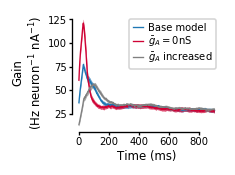

In [27]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='Base model')
visualizer.plot_gain('DRN', 'base', 'subsample_noIA', 'Principal PSTH', color=colors['4AP'], label=r'$\bar{g}_A = 0$nS')
visualizer.plot_gain('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH', color='gray', label=r'$\bar{g}_A$ increased')
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'IA_gain_illustration'))

In [28]:
def get_gain_peak(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain.max(axis=1)

def get_gain_ss(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain[:, -1000:].mean(axis=1)

def get_gain_ratio(circuit, condition, mod_type, psth_type):
    return get_gain_peak(circuit, condition, mod_type, psth_type) / get_gain_ss(circuit, condition, mod_type, psth_type)

In [29]:
pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_peak('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_peak('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).mean()

$\bar{g}_A = 0$nS        121.326011
$\bar{g}_A$ increased     57.146622
Base model                77.429061
dtype: float64

In [30]:
pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_peak('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_peak('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).std()

$\bar{g}_A = 0$nS        4.265389
$\bar{g}_A$ increased    2.604837
Base model               2.660286
dtype: float64

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
$\bar{g}_A = 0$nS v.s. Base model: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Base model v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
$\bar{g}_A = 0$nS v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Saving svg


/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saving png
Done!


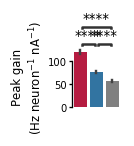

In [31]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_peak('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_peak('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_peak('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_peak('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        (r'$\bar{g}_A = 0$nS', 'Base model'),
        ('Base model', r'$\bar{g}_A$ increased'),
        (r'$\bar{g}_A = 0$nS', r'$\bar{g}_A$ increased')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'IA_and_peak_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
$\bar{g}_A = 0$nS v.s. Base model: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.098e-01 stat=3.285e+00
Base model v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=8.963e-01
$\bar{g}_A = 0$nS v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.106e-03 stat=9.846e+00
Saving svg
Saving png
Done!


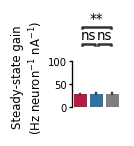

In [32]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
plt.ylim(gain_barplot_ylim)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ss('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ss('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ss('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ss('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        (r'$\bar{g}_A = 0$nS', 'Base model'),
        ('Base model', r'$\bar{g}_A$ increased'),
        (r'$\bar{g}_A = 0$nS', r'$\bar{g}_A$ increased')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')


pltools.hide_border('trb', trim=True)


if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'IA_and_ss_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
$\bar{g}_A = 0$nS v.s. Base model: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Base model v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
$\bar{g}_A = 0$nS v.s. $\bar{g}_A$ increased: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Saving svg
Saving png
Done!


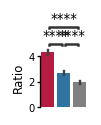

In [33]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ratio('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ratio('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ratio('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ratio('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        (r'$\bar{g}_A = 0$nS', 'Base model'),
        ('Base model', r'$\bar{g}_A$ increased'),
        (r'$\bar{g}_A = 0$nS', r'$\bar{g}_A$ increased')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Ratio')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'IA_and_gain_ratio'))

# Effect of GABA in network with IA

Saving svg
Saving png
Done!


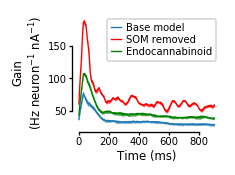

In [34]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='Base model')
visualizer.plot_gain('DRN', 'KO', 'subsample_base', 'Principal PSTH', color='red', label=r'SOM removed')
visualizer.plot_gain('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH', color='green', label=r'Endocannabinoid')
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'som_gain_illustration'))

Notice that knocking out GABA and simply removing their input have essentially the same effect on 5HT output.

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
Base model v.s. GABA removed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
GABA removed v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Base model v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Saving svg
Saving png
Done!


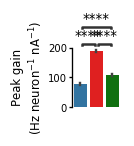

In [35]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_peak('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_peak('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        ('Base model', 'GABA removed'),
        ('Base model', 'Endocannabinoid'),
        ('GABA removed', 'Endocannabinoid')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)


if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'som_and_peak_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
Base model v.s. GABA removed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
GABA removed v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Base model v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Saving svg
Saving png
Done!


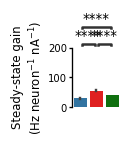

In [36]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.ylim(gain_barplot_ylim)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ss('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ss('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        ('Base model', 'GABA removed'),
        ('Base model', 'Endocannabinoid'),
        ('GABA removed', 'Endocannabinoid')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'som_and_ss_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
Base model v.s. GABA removed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
GABA removed v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.891e-07 stat=2.927e+01
Base model v.s. Endocannabinoid: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.824e-01 stat=1.686e+00
Saving svg
Saving png
Done!


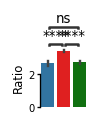

In [37]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ratio('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ratio('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[
        ('Base model', 'GABA removed'),
        ('Base model', 'Endocannabinoid'),
        ('GABA removed', 'Endocannabinoid')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Ratio')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'som_and_gain_ratio'))

## Cell type comparison

Saving svg
Saving png
Done!


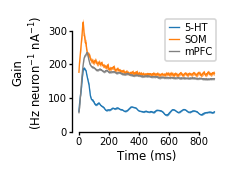

In [38]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'KO', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='5-HT')
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'GABA PSTH', color=colors['som'], label='SOM')
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH', color=colors['pyr'], label='mPFC')
plt.ylim(0, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'celltype_gain_illustration'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=0.000e+00
GABA v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=4.000e+02
5HT v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=0.000e+00
Saving svg
Saving png
Done!


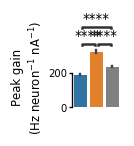

In [39]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_peak('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA', 'mPFC pyr.'],
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_peak('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
        ('5HT', 'mPFC pyr.'),
        ('GABA', 'mPFC pyr.')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'celltype_and_peak_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=0.000e+00
GABA v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=4.000e+02
5HT v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=0.000e+00
Saving svg
Saving png
Done!


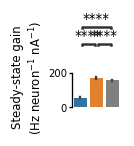

In [40]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.ylim(gain_barplot_ylim)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ss('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA', 'mPFC pyr.'],
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ss('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
        ('5HT', 'mPFC pyr.'),
        ('GABA', 'mPFC pyr.')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'celltype_and_ss_gain'))

In [41]:
pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ratio('mPFC', 'KO', 'base', 'Principal PSTH')
    }).mean()

5HT          3.420952
GABA         1.893598
mPFC pyr.    1.505169
dtype: float64

In [42]:
pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ratio('mPFC', 'KO', 'base', 'Principal PSTH')
    }).std()

5HT          0.065951
GABA         0.035715
mPFC pyr.    0.026603
dtype: float64

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=4.000e+02
GABA v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=4.000e+02
5HT v.s. mPFC pyr.: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.039e-07 U_stat=4.000e+02
Saving svg
Saving png
Done!


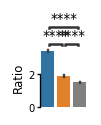

In [43]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ratio('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA', 'mPFC pyr.'],
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ratio('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
        ('5HT', 'mPFC pyr.'),
        ('GABA', 'mPFC pyr.')
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Ratio')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'celltype_and_gain_ratio'))

## Adaptation effect

Saving svg
Saving png
Done!


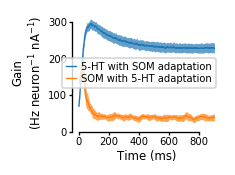

In [44]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain(
    'DRN', 
    'KO', 
    'subsample_adaptation_swap', 
    'Principal PSTH', 
    color=colors['ser'], 
    label='5-HT with SOM adaptation'
)
visualizer.plot_gain(
    'DRN', 
    'base', 
    'subsample_adaptation_swap', 
    'GABA PSTH', 
    color=colors['som'], 
    label='SOM with 5-HT adaptation'
)
plt.ylim(0, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'swapped_adaptation'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.796e-08 U_stat=4.000e+02
Saving svg
Saving png
Done!


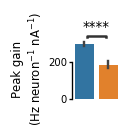

In [45]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA'],
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_peak_gain'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.796e-08 U_stat=4.000e+02
Saving svg
Saving png
Done!


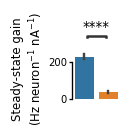

In [46]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.ylim(gain_barplot_ylim)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA'],
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_ss_gain'))

In [47]:
pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).mean()

5HT     1.304265
GABA    4.835856
dtype: float64

In [48]:
pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).std()

5HT     0.058382
GABA    0.671438
dtype: float64

In [49]:
stats.mannwhitneyu(
    get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
    get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
5HT v.s. GABA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.796e-08 U_stat=0.000e+00
Saving svg
Saving png
Done!


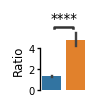

In [50]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
plt.subplots_adjust(left=0.55, bottom=0.2, top=0.70, right=0.95)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
add_stat_annotation(
    ax=ax,
    plot='barplot',
    x='variable',
    y='value',
    order=['5HT', 'GABA'],
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    comparisons_correction='bonferroni',
    test='Mann-Whitney',
    box_pairs=[
        ('5HT', 'GABA'),
    ],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
plt.ylabel('Ratio')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_gain_ratio'))

## Homogeneity

In [ ]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain(
    'DRN', 
    'KO', 
    'homogenous_base', 
    'Principal PSTH', 
    color=colors['ser'], 
    label='Homogenous 5HT'
)
visualizer.plot_gain(
    'DRN', 
    'base', 
    'homogenous_base', 
    'GABA PSTH', 
    color=colors['som'], 
    label='Homogenous GABA'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'homogenous_populations.png'))
    plt.savefig(os.path.join(IMG_PATH, 'homogenous_populations.svg'))